In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "SRS"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn025861,MNDNPINPAIIGKARQKRKKSIIPNEKPVFVPVINSRKEKNRKEKE...,280,1
1,Achn049041,MSGFFSLGGKQEKSTTTNSLFLLRNEEIYNKSFELWQQYYHLHQQK...,280,1
2,Achn084931,MSAVVATTRRFPSDSGAFADWVASSSSSGPRATEDLSLGFNAGGGS...,390,1
3,Achn131151,MRPGMNCQDCGNQAKKDCVHLRCRTCCKSWGLPCQTHVKSTWVPAA...,210,1
4,Achn135131,MAGFFSLGGGRETNTNDQDHQQQTQNPNNPVAEISPENWFLYRNED...,318,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1516,0.020501,0.002278,0.011390,0.004556,0.000000,0.006834,0.006834,0.000000,0.000000,0.002278,...,0.002278,0.000000,0.000000,0.006834,0.004556,0.0,0.0,0.000000,0.0,0.0
187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004975,0.004975,0.000000,...,0.000000,0.000000,0.004975,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
413,0.010989,0.000000,0.000000,0.000000,0.005495,0.000000,0.005495,0.000000,0.005495,0.005495,...,0.000000,0.000000,0.005495,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2148,0.000000,0.000000,0.003003,0.000000,0.000000,0.006006,0.000000,0.006006,0.006006,0.003003,...,0.000000,0.003003,0.000000,0.003003,0.000000,0.0,0.0,0.003003,0.0,0.0
2,0.020566,0.000000,0.005141,0.000000,0.002571,0.010283,0.000000,0.000000,0.002571,0.002571,...,0.000000,0.000000,0.002571,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2103, 440)
X_test: (526, 440)
y_train: (2103,)
y_test: (526,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,161 (610.00 KB)

 Trainable params: 156,161 (610.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 16s 637ms/step - accuracy: 0.6406 - loss: 0.6930

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5949 - loss: 0.6809 - val_accuracy: 0.8195 - val_loss: 0.5555


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7656 - loss: 0.5549

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8978 - loss: 0.4542 - val_accuracy: 0.9620 - val_loss: 0.1541


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.1256

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9656 - loss: 0.1448 - val_accuracy: 0.9667 - val_loss: 0.1040


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.1535

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9634 - loss: 0.0994 - val_accuracy: 0.9857 - val_loss: 0.0552


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0384

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9918 - loss: 0.0393 - val_accuracy: 0.9857 - val_loss: 0.0507


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0161

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9971 - loss: 0.0175 - val_accuracy: 0.9905 - val_loss: 0.0470


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0064

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0212 - val_accuracy: 0.9905 - val_loss: 0.0476


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0020

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0129 - val_accuracy: 0.9905 - val_loss: 0.0526


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0015

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0124 - val_accuracy: 0.9739 - val_loss: 0.0748


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0139

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0104 - val_accuracy: 0.9857 - val_loss: 0.0516


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.9534e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0098 - val_accuracy: 0.9905 - val_loss: 0.0497


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0036

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0100 - val_accuracy: 0.9905 - val_loss: 0.0422


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0065

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0031 - val_accuracy: 0.9857 - val_loss: 0.0545


Epoch 14/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0047

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0139 - val_accuracy: 0.9905 - val_loss: 0.0516


Epoch 15/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0040

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9905 - val_loss: 0.0450


Epoch 16/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0038

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9905 - val_loss: 0.0418



[Train Accuracy: 100.00% - Test Accuracy: 99.05%]


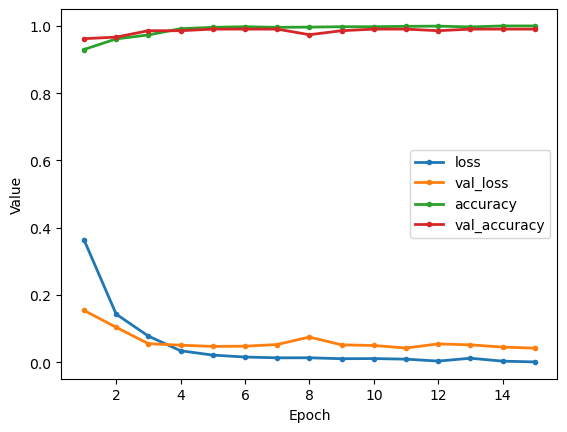

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1516,0.011416,0.0,0.002283,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,0.000000,0.0,0.000000,0.0,0.005525,0.000000,0.005525,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2148,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002577,0.0,0.002577,0.0,0.000000,0.002577,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2103, 8498)
X_test: (526, 8498)
y_train: (2103,)
y_test: (526,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,175,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,219,009 (8.46 MB)

 Trainable params: 2,219,009 (8.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 16s 641ms/step - accuracy: 0.5156 - loss: 0.6931

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5577 - loss: 0.6921   

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6521 - loss: 0.6884

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7095 - loss: 0.6806

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7253 - loss: 0.6768 - val_accuracy: 0.9572 - val_loss: 0.4777


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9688 - loss: 0.4764

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9632 - loss: 0.4335 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9626 - loss: 0.3841

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9644 - loss: 0.3397

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9653 - loss: 0.3255 - val_accuracy: 0.9929 - val_loss: 0.0331


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9688 - loss: 0.0593

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9799 - loss: 0.0471 

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9853 - loss: 0.0383

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9879 - loss: 0.0337

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9884 - loss: 0.0327 - val_accuracy: 0.9976 - val_loss: 0.0065


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0075

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0053 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0061

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0059

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9988 - loss: 0.0058 - val_accuracy: 0.9976 - val_loss: 0.0048


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.8854e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3407e-04 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7158e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4180e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 9.5159e-04 - val_accuracy: 0.9976 - val_loss: 0.0046


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.2028e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011     

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5081e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 9.1308e-04 - val_accuracy: 0.9976 - val_loss: 0.0045


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0011

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3507e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0390e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6825e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 6.5565e-04 - val_accuracy: 0.9976 - val_loss: 0.0044


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.4942e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6425e-04 

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6825e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7513e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7829e-04 - val_accuracy: 0.9976 - val_loss: 0.0049


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.5850e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6543e-04 

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7964e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7755e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7839e-04 - val_accuracy: 0.9976 - val_loss: 0.0047


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3954e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0103e-04 

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2412e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2034e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1725e-04 - val_accuracy: 0.9976 - val_loss: 0.0045


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.3004e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4734e-04 

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6061e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8299e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.8935e-04 - val_accuracy: 0.9976 - val_loss: 0.0038


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0023

 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7496e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9586e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7101e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.3265e-04 - val_accuracy: 0.9976 - val_loss: 0.0069


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.5461e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5699e-05 

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6929e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4151e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.3905e-05 - val_accuracy: 0.9976 - val_loss: 0.0052



[Train Accuracy: 100.00% - Test Accuracy: 99.81%]


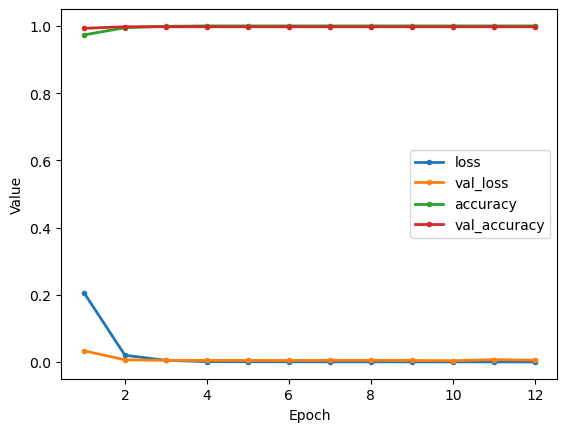

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1516,0.002288,0.0,0.002288,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2148,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.002584,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      30,953,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,994,433 (118.23 MB)

 Trainable params: 30,994,433 (118.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 21s 823ms/step - accuracy: 0.5625 - loss: 0.6931

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5586 - loss: 0.6931  

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5460 - loss: 0.6931

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5501 - loss: 0.6930

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5601 - loss: 0.6929

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5727 - loss: 0.6928

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5833 - loss: 0.6927

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5929 - loss: 0.6926

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6013 - loss: 0.6924

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6099 - loss: 0.6922

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6187 - loss: 0.6920

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6275 - loss: 0.6918

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6358 - loss: 0.6915

14/27 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6438 - loss: 0.6913

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6518 - loss: 0.6909

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6594 - loss: 0.6906

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6667 - loss: 0.6903

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6738 - loss: 0.6899

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6805 - loss: 0.6895

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6870 - loss: 0.6890

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6932 - loss: 0.6885

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6992 - loss: 0.6880

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7048 - loss: 0.6874

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7102 - loss: 0.6868

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7154 - loss: 0.6861

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7203 - loss: 0.6853

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7249 - loss: 0.6846

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.7292 - loss: 0.6840 - val_accuracy: 0.9691 - val_loss: 0.5724


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9688 - loss: 0.5800

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9648 - loss: 0.5755 

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9661 - loss: 0.5709

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9688 - loss: 0.5664

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9712 - loss: 0.5621

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9730 - loss: 0.5580

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9743 - loss: 0.5541

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9756 - loss: 0.5498

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9767 - loss: 0.5455

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9777 - loss: 0.5410

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9783 - loss: 0.5364

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9787 - loss: 0.5318

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9791 - loss: 0.5272

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9795 - loss: 0.5225

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9798 - loss: 0.5176

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9800 - loss: 0.5128

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9802 - loss: 0.5079

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9803 - loss: 0.5029

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9805 - loss: 0.4979

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9807 - loss: 0.4929

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9809 - loss: 0.4878

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9811 - loss: 0.4828

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9813 - loss: 0.4777

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9815 - loss: 0.4727

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9817 - loss: 0.4677

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9818 - loss: 0.4627

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9819 - loss: 0.4580

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9820 - loss: 0.4536 - val_accuracy: 0.9929 - val_loss: 0.0777


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 1.0000 - loss: 0.0545

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.0561

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0567

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0564

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0559

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0549

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0538

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0525

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9998 - loss: 0.0514

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9997 - loss: 0.0503

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9994 - loss: 0.0493

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9993 - loss: 0.0483

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9991 - loss: 0.0473

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9990 - loss: 0.0464

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9989 - loss: 0.0455

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9988 - loss: 0.0447

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9987 - loss: 0.0440

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9986 - loss: 0.0433

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9985 - loss: 0.0426

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9984 - loss: 0.0419

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9983 - loss: 0.0413

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9983 - loss: 0.0406

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9982 - loss: 0.0400

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9982 - loss: 0.0395

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9982 - loss: 0.0389

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9981 - loss: 0.0383

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9981 - loss: 0.0378

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9981 - loss: 0.0373 - val_accuracy: 0.9952 - val_loss: 0.0135


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 1.0000 - loss: 0.0044

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0040

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0038

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0042

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0043

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0043

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0043

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0042

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0042

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0041

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0041

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0040

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0040

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0040

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0039

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0039

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0038

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0038

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0038

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0037

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0037

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0037

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0037

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0036

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0036

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0036

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0036

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9952 - val_loss: 0.0100


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 1.0000 - loss: 0.0027

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0024

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0024

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0023

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0022

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0021

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0021

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0020

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0020

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0020

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0019

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0019

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0019

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0018

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0018

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0018

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0018

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0018

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0018

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0017

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0017

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0017

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0017

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0017

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0017

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0016

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0016

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9952 - val_loss: 0.0097


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 0.0013

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0012

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0012

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0011

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0011

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0011

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0011

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0011

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0010

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0010

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0010

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0010

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0010

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0010

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0010

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0010

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0010

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0010

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0010

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.9997e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.9579e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.9229e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.8848e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.8447e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.8045e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.7652e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 9.7295e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 9.6963e-04 - val_accuracy: 0.9952 - val_loss: 0.0094


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 5.1687e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 5.0525e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 5.6557e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 5.8132e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 6.0162e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 6.1060e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 6.1346e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 6.1486e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 6.1627e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 6.1453e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 6.1159e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 6.0797e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 6.0331e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 5.9975e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 5.9628e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 5.9426e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 5.9181e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 5.9018e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 5.8922e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 5.8829e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 5.8947e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 5.9046e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 5.9120e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 5.9146e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 5.9155e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 5.9149e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 5.9125e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 5.9103e-04 - val_accuracy: 0.9952 - val_loss: 0.0098


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 5.7483e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 5.1365e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 5.1444e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 5.0570e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 4.9838e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 4.8924e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 4.8501e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 4.7916e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 4.7459e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 4.7029e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 4.6633e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 4.6535e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 4.6336e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.6040e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.5788e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.5493e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.5172e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.4863e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.4557e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.4243e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.3930e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.3618e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.3306e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.3006e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.2725e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 4.2465e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 4.2227e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 4.2006e-04 - val_accuracy: 0.9952 - val_loss: 0.0102


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 1.0000 - loss: 2.0431e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.2288e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 2.3456e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.5220e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.5910e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.6239e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.6221e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.6196e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.6008e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.5764e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.5691e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.5590e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.5466e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 2.5335e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.5222e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.5180e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.5122e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.5070e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.5079e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.5097e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.5091e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.5070e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.5077e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.5092e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.5089e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.5089e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 2.5082e-04 - val_accuracy: 0.9952 - val_loss: 0.0104


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 4.5974e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 3.9449e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 3.5928e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 3.4444e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 3.3265e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 3.2054e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 3.0921e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 2.9925e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 2.9050e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 2.8257e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 2.7516e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 2.6885e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.6295e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.5730e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.5212e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.4725e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.4310e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.3938e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.3591e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.3282e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.3026e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.2789e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.2566e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.2351e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.2168e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.2009e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.1860e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 2.1722e-04 - val_accuracy: 0.9952 - val_loss: 0.0102


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 1.2001e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.1817e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.1897e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.1752e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.1671e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.1879e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.2356e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.2764e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.3020e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.3224e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.3363e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.3469e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.5653e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7341e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.8793e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9941e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.0855e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.1615e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.2233e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.2795e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.3250e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.3616e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.3925e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.4179e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.4384e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.4548e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.4695e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 2.4831e-04 - val_accuracy: 0.9952 - val_loss: 0.0067


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 2.2204e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.9573e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.9039e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.8714e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.8543e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.8285e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.8034e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7747e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7466e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7295e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7085e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7149e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7145e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7113e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7098e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7100e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7117e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7123e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7105e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7070e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7044e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.7014e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.6986e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.6957e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.6918e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.6869e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 1.6791e-04 - val_accuracy: 0.9952 - val_loss: 0.0090


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 8.8065e-05

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.6387e-05

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 9.9917e-05

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.0133e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0245e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0245e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0190e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0218e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.0229e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.0231e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.0210e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.0182e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.0135e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0079e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0031e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 9.9895e-05

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 9.9359e-05

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0153e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0325e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0505e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0658e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0786e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0894e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0989e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.1064e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.1124e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.1176e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 1.1224e-04 - val_accuracy: 0.9952 - val_loss: 0.0095



[Train Accuracy: 100.00% - Test Accuracy: 99.81%]


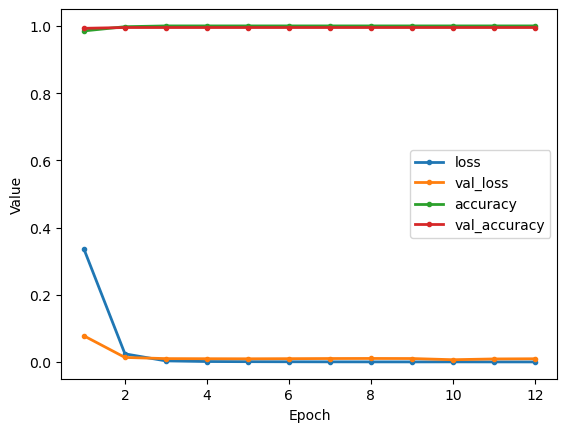

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
report.save()

Report saved as Output/Reports/SRS/report_R5NEU34T.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################